Changing configuration options and their values bear the risk of introducing **configuration errors** due to the violation of their constraints and dependencies. With *CfgNet* we already detect potential dependency conflicts, but miss the violation of constraints. To detect violation of constraints, we analzye file diffs via LLMs to validate the changes made.

In [1]:
import json
from typing import Dict, Any
from openai import OpenAI
import matplotlib.pyplot as plt
from collections import Counter
import os
import pandas as pd
import glob

*How many potential dependency conflicts are detected?*

In [4]:
def get_conflicts(data: Dict) -> pd.DataFrame:
    
    config_commits = [commit for commit in data["commit_data"] if commit["is_config_related"]]
    total_conflicts = sum(len(commit["conflicts"]) for commit in config_commits)
    avg_conflicts = round(total_conflicts / len(config_commits) if config_commits else 0, 2)
    
    # Create a DataFrame to store the results
    df = pd.DataFrame({
        "project_name": [data["project_name"]],
        "total_conflicts": [total_conflicts],
        "avg_conflicts": [avg_conflicts],
        "num_config_commits": [len(config_commits)],
        "num_commits": [len(data["commit_data"])]
    })

    return df

project_files = glob.glob("../data/test_projects/*.json")[:10]

df_list = []
for project_file in project_files:
    with open(project_file, "r") as f:
        data = json.load(f)
    
        df_list.append(get_conflicts(data))

df_all = pd.concat(df_list, ignore_index=True)
df_all

,project_name,total_conflicts,avg_conflicts,num_config_commits,num_commits
0,yas,987,2.40,411,825
1,piggymetrics,77,0.57,135,290
2,jetlinks-community,143,0.34,417,1307
3,yuzi-generator,17,0.81,21,33
4,test-config-repo,3,0.43,7,7
5,litemall,1017,3.04,334,1189


*What kind of dependency conflicts are deteced?*

In [5]:
def show_conflicts(data: Dict) -> pd.DataFrame:
    
    detected_conflicts = []
    config_commits = [commit for commit in data["commit_data"] if commit["is_config_related"]]

    for commit in config_commits:
        if commit["conflicts"]:
            for conflict in commit["conflicts"]:
                detected_conflicts.append(conflict)
    
    # Create a DataFrame to store the results
    df = pd.DataFrame(detected_conflicts)

    return df

data_file = "../data/test_projects/piggymetrics.json"
with open(data_file, "r") as f:
    data = json.load(f)

df_conflicts = show_conflicts(data)
df_conflicts.head(50)

,link,conflict_type,occurred_at,fixed,config_type,artifact,option,value,old_value,dependent_artifact,dependent_option,dependent_value
0,tmpd_q56rcf::::account-service/pom.xml::::proj...,ModifiedOptionConflict,16898ef14d6cd4a98d3bebe795867b5b5a68a7a7,False,ConfigType.VERSION_NUMBER <-> ConfigType.VERSI...,auth-service/pom.xml,version,1.3.2.RELEASE,1.3.1.RELEASE,account-service/pom.xml,version,1.3.1.RELEASE
1,tmpd_q56rcf::::account-service/pom.xml::::proj...,ModifiedOptionConflict,16898ef14d6cd4a98d3bebe795867b5b5a68a7a7,False,ConfigType.VERSION_NUMBER <-> ConfigType.VERSI...,gateway/pom.xml,version,1.3.2.RELEASE,1.3.1.RELEASE,account-service/pom.xml,version,1.3.1.RELEASE
2,tmpd_q56rcf::::account-service/pom.xml::::proj...,ModifiedOptionConflict,16898ef14d6cd4a98d3bebe795867b5b5a68a7a7,False,ConfigType.VERSION_NUMBER <-> ConfigType.VERSI...,account-service/pom.xml,version,1.3.2.RELEASE,1.3.1.RELEASE,account-service/pom.xml,version,1.3.1.RELEASE
3,tmpd_q56rcf::::account-service/pom.xml::::proj...,ModifiedOptionConflict,16898ef14d6cd4a98d3bebe795867b5b5a68a7a7,False,ConfigType.VERSION_NUMBER <-> ConfigType.VERSI...,statistics-service/pom.xml,version,1.3.2.RELEASE,1.3.1.RELEASE,account-service/pom.xml,version,1.3.1.RELEASE
4,tmpd_q56rcf::::account-service/Dockerfile::::E...,ModifiedOptionConflict,55452de1a09696052991533ac8fd2eaf73f44ded,False,ConfigType.PORT <-> ConfigType.PORT,gateway/Dockerfile,EXPOSE,4000,8080,account-service/Dockerfile,EXPOSE,8080
5,tmpd_q56rcf::::account-service/src/main/resour...,ModifiedOptionConflict,55452de1a09696052991533ac8fd2eaf73f44ded,False,ConfigType.USERNAME <-> ConfigType.USERNAME,account-service/src/main/resources/application...,spring.data.mongodb.username,user,service,statistics-service/src/main/resources/applicat...,spring.data.mongodb.username,service
6,tmpd_q56rcf::::account-service/src/main/resour...,ModifiedOptionConflict,4861548f29c120492db2fb0897674b5d149512e0,False,ConfigType.TIME <-> ConfigType.TIME,gateway/src/main/resources/application.yml,hystrix.command.default.execution.isolation.th...,20000,10000,account-service/src/main/resources/application...,hystrix.command.default.execution.isolation.th...,10000
7,tmpd_q56rcf::::account-service/src/main/resour...,ModifiedOptionConflict,4861548f29c120492db2fb0897674b5d149512e0,False,ConfigType.TIME <-> ConfigType.TIME,gateway/src/main/resources/application.yml,zuul.host.connect-timeout-millis,20000,10000,account-service/src/main/resources/application...,hystrix.command.default.execution.isolation.th...,10000
8,tmpd_q56rcf::::account-service/src/main/resour...,ModifiedOptionConflict,4861548f29c120492db2fb0897674b5d149512e0,False,ConfigType.TIME <-> ConfigType.TIME,gateway/src/main/resources/application.yml,zuul.host.socket-timeout-millis,20000,10000,account-service/src/main/resources/application...,hystrix.command.default.execution.isolation.th...,10000
9,tmpd_q56rcf::::account-service/src/main/resour...,ModifiedOptionConflict,2848d153eb5d4cd83f7fb4694a44ec8a4b8bf7ce,False,ConfigType.UNKNOWN <-> ConfigType.UNKNOWN,statistics-service/src/main/resources/applicat...,security.oauth2.client.clientSecret,${STATISTICS_SERVICE_PASSWORD},password,account-service/src/main/resources/application...,security.oauth2.client.clientSecret,password


*What types of configuration options are involved in potential dependency conflicts?*

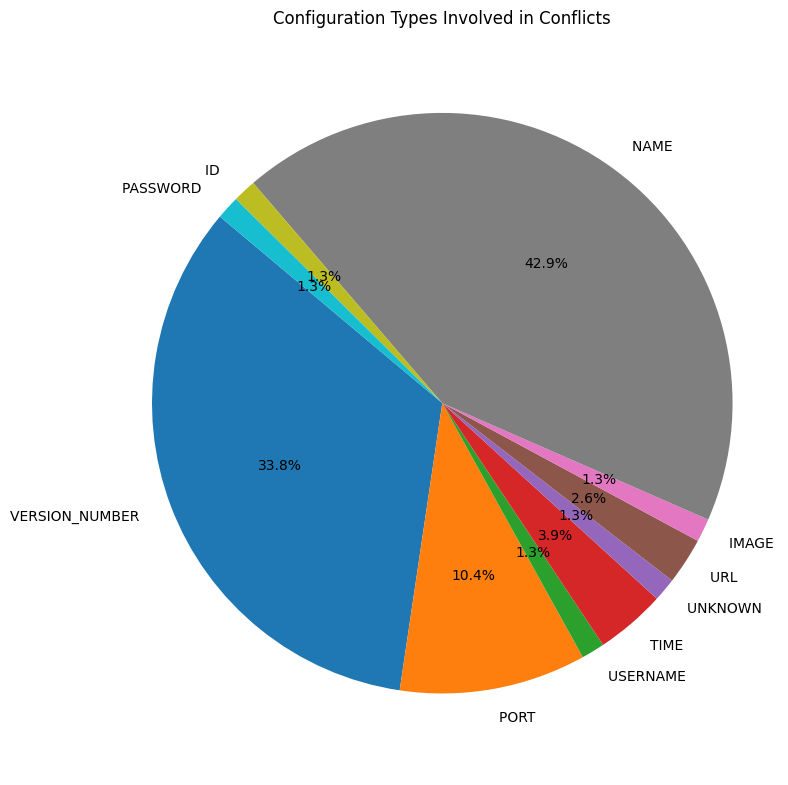

In [ ]:
def plot_config_types_conflicts(data: Dict) -> pd.DataFrame:
    
    config_types_involved = []
    config_commits = [commit for commit in data["commit_data"] if commit["is_config_related"]]
    total_conflicts = 0

    for commit in config_commits:
        if commit["conflicts"]:
            for conflict in commit["conflicts"]:
                if conflict["conflict_type"] == "ModifiedOptionConflict" not in config_types_involved:
            
                    config_type = conflict["config_type"].split("<->")[0].split(".")[-1]
                    config_types_involved.append(config_type)

                total_conflicts += 1

    type_counter = Counter(config_types_involved)
    df = pd.DataFrame(type_counter.items(), columns=["Config Type", "Count"])

    # Plot pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(df["Count"], labels=df["Config Type"], autopct="%1.1f%%", startangle=140)
    plt.title("Configuration Types Involved in Conflicts")
    plt.axis("equal")
    plt.tight_layout()
    plt.show()           
    

data_file = "../data/test_projects/piggymetrics.json"
with open(data_file, "r") as f:
    data = json.load(f)

plot_config_types_conflicts(data)

This part of the notebook represents an early idea: Analying commit-diff to practively detect configuration errors using LLMs. 

*Does configuration changes introduce misconfigurations?*

In [ ]:


SYSTEM_PROMPT = """
You are a code review assistant with an excellent knowledge about configuration constraints and dependencies. 
Your task is to analyze the changes in the provided file diffs of a given commit and determine if they introduce any configuration errors.
"""

USER_PROMPT = """
Analyze the following file diffs and validate if the changes introduce any configuration errors:
{commit_diff}

For any potential configuration error, respond in a JSON format as shown below:
{{
"hasError": boolean, // true if there are errors, false if there are none 
"errParameter": [], // List containing properties with errors 
"reason": [], // List containing explanations for each error
}}
"""


def validate_commit_diffs(commit_diff: str) -> Dict:
    """Validate if the changes introduce configuration errors."""
    client = OpenAI(
        api_key=os.getenv("PROXY_SERVER_API_KEY"),
        base_url=os.getenv("BASE_URL")
    )

    messages = [
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": USER_PROMPT.format(commit_diff=commit_diff)}
    ]

    response = client.chat.completions.create(
        model="gpt-4o-mini-2024-07-18", 
        messages=messages,        
        temperature=0.0,
        response_format={"type": "json_object"},
        max_tokens=100,
        timeout=90
    )

    return response.choices[0].message.content

In [ ]:
from dotenv import load_dotenv

load_dotenv(dotenv_path="../.env")

def detect_config_errors(project_data: Dict[str, Any]) -> None:
    """Detect configuration errors in the project data."""
    
    errors = []

    for commit in project_data["commit_data"]:
        if not commit["is_config_related"]:
            continue

        config_files = commit["network_data"]["config_files_data"]

        file_diffs = []

        for config_file in config_files:
            if config_file["is_modified"] and len(config_file["modified_pairs"]) > 0: 
                file_diffs.append(config_file["file_diff"])

        commit_diff = "\n\n".join(file_diffs)

        if not commit_diff:
            continue

        response = validate_commit_diffs(commit_diff=commit_diff)
        detected_error = json.loads(response)
        detected_error["file_path"] = config_file["file_path"]
        detected_error["commit_hash"] = commit["commit_hash"]
        errors.append(detected_error)


    for error in errors:
        print("File Path: ", error["file_path"])
        print("Commit Hash: ", error["commit_hash"])
        print("Has Error: ", error["hasError"])
        print("Error Parameters: ", error["errParameter"])
        print("Reasons: ", error["reason"])
        print()


project_file = "../data/microservice_projects/test-config-repo.json"	
with open(project_file, "r") as f:
    project_data = json.load(f)

detect_config_errors(project_data)


In [ ]:
project_file = "../data/microservice_projects/piggymetrics.json"	
with open(project_file, "r") as f:
    project_data = json.load(f)


for commit in project_data["commit_data"]:
    conflicts = commit["conflicts"]
    if conflicts:
        print("Commit Hash: ", commit["commit_hash"])
        for conflict in conflicts:
            print("Missing Link: ", conflict["link"])
        
    

*How many config-related commits are also error-related?*

Counter({'non_config': 155, 'config_non_error': 127, 'config_error': 8})


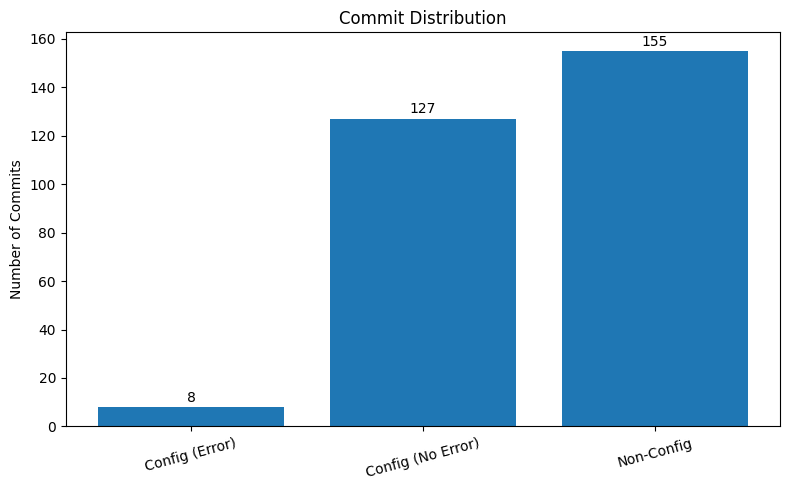

In [9]:
keywords = {"conflict", "error", "issue", "problem", "bug", "fail", "invalid", "incorrect"}

def classify_commits(data):
    counts = Counter()

    for commit in data["commit_data"]:
        msg = commit["commit_mgs"].lower()
        is_config = commit["is_config_related"]

        if is_config:
            if any(keyword in msg for keyword in keywords):
                counts["config_error"] += 1
            else:
                counts["config_non_error"] += 1
        else:
            counts["non_config"] += 1

    return counts


def plot_commit_classification(commit_counts):
    labels = ["Config (Error)", "Config (No Error)", "Non-Config"]
    values = [
        commit_counts["config_error"],
        commit_counts["config_non_error"],
        commit_counts["non_config"]
    ]

    plt.figure(figsize=(8, 5))
    bars = plt.bar(labels, values)
    plt.title("Commit Distribution")
    plt.ylabel("Number of Commits")
    plt.xticks(rotation=15)

    # Annotate bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, yval + 1, int(yval), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

data_file = "../data/test_projects/piggymetrics.json"
with open(data_file, "r") as f:
    data = json.load(f)

commit_counts = classify_commits(data)
print(commit_counts)
plot_commit_classification(commit_counts)
